# Homework 4: Modeling Text Data

### Team Member 1:
* UNI: kc3057  
* Name: Kaavya Chinniah

### Team Member 2 [optional]:
* UNI: as5196
* Name: Amla Srivastava


You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

##### Loading the data as panda dataframe

Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1019]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.feature_extraction.text import CountVectorizer,  ENGLISH_STOP_WORDS, TfidfVectorizer , HashingVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import mglearn
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.preprocessing import MaxAbsScaler, Normalizer, StandardScaler
from sklearn.cluster import KMeans
from __future__ import print_function
from gensim import models
from gensim.models.keyedvectors import KeyedVectors
% matplotlib inline

In [3]:
df=pd.read_csv('data.csv')
# aa=df
df.shape

(8534, 11)

In [4]:
df.head()

,﻿X,Y,OBJECTID,GLOBALID,REQUESTID,REQUESTTYPE,REQUESTDATE,STATUS,STREETSEGID,COMMENTS,USERTYPE
0,-71.071329,42.332161,15607,NaN,15607.0,bike facilities don't exist or need improvement,2016-01-19T22:14:26.000Z,Unassigned,0,the roadway is super wide here with no lane ma...,bikes
1,-71.067764,42.374244,15608,NaN,15608.0,"the wait for the ""Walk"" signal is too long",2016-01-19T22:55:29.000Z,Unassigned,0,As someone who walks from SE of the intersecti...,walks
2,-71.066077,42.374768,15609,NaN,15609.0,people cross away from the crosswalks,2016-01-19T22:57:09.000Z,Unassigned,0,I'm one of those people. Many people walk nort...,walks
3,-71.152978,42.345312,16007,NaN,16007.0,people speed,2016-01-19T23:33:20.000Z,Unassigned,0,NaN,walks
4,-71.070658,42.351921,16008,NaN,16008.0,people don't yield while turning,2016-01-19T23:39:45.000Z,Unassigned,0,People do not understand which lane to move in...,drives


##### Visualising Class Distribution

Distribution of target variable- REQUESTTYPE with counts

In [5]:
pd.crosstab(index=df["REQUESTTYPE"],  
                      columns="count")

col_0,count
REQUESTTYPE,
""" src=""images/01 - Not enough time to cross.png""></span>&nbsp;there's not enough time to cross the street",1
""" src=""images/02 - Wait is too long.png""></span>&nbsp;the wait for the ""Walk"" signal is too long",3
""" src=""images/06 - Speeding.png""></span>&nbsp;people speed",3
""" src=""images/10 - Hard to see.png""></span>&nbsp;it’s hard to see / low visibility",2
""" src=""images/11 - Sidewalk issue.png""></span>&nbsp;sidewalks/ramps don't exist or need improvement",2
""" src=""images/12 - Bike facility issue.png""></span>&nbsp;the roadway surface needs improvement",1
""" src=""images/14 - Other issue.png""></span>&nbsp;of something that is not listed here",3
bike facilities don't exist or need improvement,1136
it's too far / too many lanes to cross,137


##### Cleaning up Target Variables

Here, we find that the certian REQUESTTYPE have been recorded incorrectly and have to be cleaned.          
Extracting requesttype after characters from "src ....  ;"

In [6]:
df['REQUESTTYPE'].replace(regex=True,inplace=True,to_replace=r'src=".*&nbsp;',value=r'')
df['REQUESTTYPE'].replace(regex=True,inplace=True,to_replace=r'"',value=r'')
df['REQUESTTYPE'] = df['REQUESTTYPE'].map(lambda x: x.strip())

In [7]:
pd.crosstab(index=df["REQUESTTYPE"],  
                      columns="count")

col_0,count
REQUESTTYPE,
bike facilities don't exist or need improvement,1136
it's too far / too many lanes to cross,137
it’s hard for people to see each other,29
it’s hard to see / low visibility,434
of something that is not listed here,1433
people are not given enough time to cross the street,12
people cross away from the crosswalks,294
people don't yield while going straight,364
people don't yield while turning,645


##### Consolidating categories

In [8]:
def category(c):
    if c['REQUESTTYPE'] in ('it’s hard for people to see each other'
                            ,'it’s hard to see / low visibility'):
        return 'Visibility'
    elif c['REQUESTTYPE'] in ('people have to wait too long for the Walk signal',
                              'the wait for the Walk signal is too long'):
        return 'Wait time'
    elif c['REQUESTTYPE'] in ('bike facilities don\'t exist or need improvement',
                              'there are no bike facilities or they need maintenance'):
        return 'Bike Facilities'
    elif c['REQUESTTYPE'] in ('it\'s too far / too many lanes to cross',
                              'people have to cross too many lanes / too far'):
        return 'Too far'
    elif c['REQUESTTYPE'] in ('the roadway surface needs improvement',
                              'the roadway surface needs maintenance'):
        return 'roadway surface'
    elif c['REQUESTTYPE'] in ('sidewalks/ramps don\'t exist or need improvement',
                              'there are no sidewalks or they need maintenance'):
        return 'Side walk'
    elif c['REQUESTTYPE'] in ('people are not given enough time to cross the street',
                              'there\'s not enough time to cross the street'):
        return 'cross the street'
    else:
        return c['REQUESTTYPE']

In [9]:
df['category'] = df.apply(category, axis=1)

In [10]:
pd.crosstab(index=df["category"],  
                      columns="count")

col_0,count
category,
Bike Facilities,1279
Side walk,372
Too far,167
Visibility,463
Wait time,342
cross the street,191
of something that is not listed here,1433
people cross away from the crosswalks,294
people don't yield while going straight,364


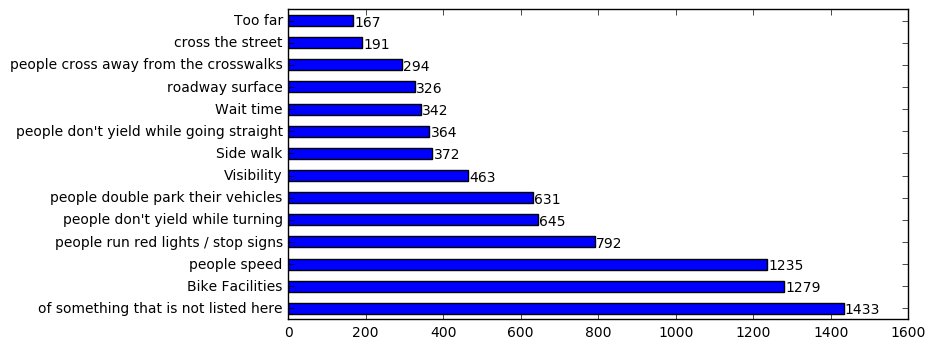

In [11]:
import matplotlib.pyplot as plt
y_mem = df.category
yy=pd.DataFrame(y_mem.value_counts())
yy.reset_index(level=0, inplace=True)
yy=yy['category'].tolist()
# data_mem = members.fullName
plt.figure(figsize=(8, 4))
(y_mem.value_counts()).plot(kind='barh')
for i, v in enumerate(yy):
    plt.text(v + 3, i-0.25 , str(v), color='black')
plt.show()

##### Removing duplicate data points considering only the COMMENTS and REQUESTTYPE column 

In [12]:
df.shape

(8534, 12)

In [13]:
no_dup=df.drop_duplicates(subset=['COMMENTS', 'REQUESTTYPE'], take_last=True)
no_dup.shape

(6481, 12)

In [1079]:
aa=pd.crosstab(index=no_dup["category"],  
                      columns="count")
aa

col_0,count
category,
Bike Facilities,820
Side walk,341
Too far,111
Visibility,413
Wait time,230
cross the street,133
of something that is not listed here,1401
people cross away from the crosswalks,256
people don't yield while going straight,257


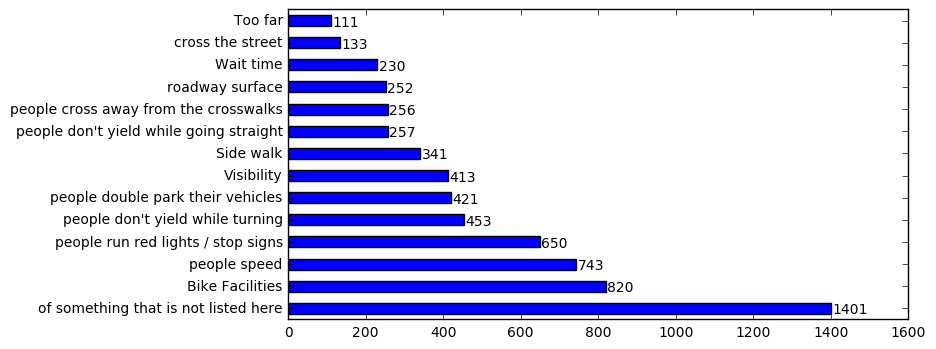

In [15]:
y_mem = no_dup.category
yy=pd.DataFrame(y_mem.value_counts())
yy.reset_index(level=0, inplace=True)
yy=yy['category'].tolist()
# data_mem = members.fullName
plt.figure(figsize=(8, 4))
(y_mem.value_counts()).plot(kind='barh')
for i, v in enumerate(yy):
    plt.text(v + 3, i-0.25 , str(v), color='black')
plt.show()

In [16]:
yy

[1401, 820, 743, 650, 453, 421, 413, 341, 257, 256, 252, 230, 133, 111]

# Task2 - Model 1 [10 points]

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

Converting the categories to discrete numerical categories

In [17]:
df=no_dup
df.shape

(6481, 12)

In [18]:
df.category = pd.Categorical(df.category)
df['TARGET'] = df.category.cat.codes

In [19]:
text_train= list(df["COMMENTS"].map(str)+df["USERTYPE"])
y=list(df["TARGET"])
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train))) 
print("text_train[1]:\n{}".format(text_train[1]))

type of text_train: <class 'list'>
length of text_train: 6481
text_train[1]:
As someone who walks from SE of the intersection, I have to make multiple crossings to get to the T station. It's obvious from experience that I can safely cross at times when it says not to walk. Update the signals.walks


Here, text_train is a list of length 6481 where each entry is a string containing a comment on complaint+usertype

In [20]:
print("Samples per class (test): {}".format(np.bincount(y)))

Samples per class (test): [ 820  341  111  413  230  133 1401  256  257  453  421  650  743  252]


##### Exploring Data

Counting number of comments with entries NaN

In [21]:
print("No. of rows with comments as NaN : ",sum(pd.isnull(df['COMMENTS'])))
print("Precentage : {:.3f} % ".format(sum(pd.isnull(df['COMMENTS']))/df.shape[0]*100))

No. of rows with comments as NaN :  21
Precentage : 0.324 % 


Since 0.324% of the rows of comment have NaN values and the target values are learnt based on comment mainly, it would be better to drop these rows

In [22]:
df = df[pd.notnull(df['COMMENTS'])]
df.shape

(6460, 13)

In [1032]:
text_train= list(df["COMMENTS"].map(str)+df["USERTYPE"])
y=list(df["TARGET"])
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train))) 
print("text_train[1]:\n{}".format(text_train[1]))

type of text_train: <class 'list'>
length of text_train: 6460
text_train[1]:
As someone who walks from SE of the intersection, I have to make multiple crossings to get to the T station. It's obvious from experience that I can safely cross at times when it says not to walk. Update the signals.walks


In [24]:
from sklearn.metrics import precision_score,recall_score,f1_score
def score(X,y,clf):
    print('Score: {:.3f} %'.format(clf.score(X,y)*100))
#     print('Precision: {:.3f} %'.format(precision_score(y, clf.predict(X),average = 'binary')*100))
#     print('Recall: {:.3f} %'.format(recall_score(y, clf.predict(X))*100))
    print('F1 Score: {:.3f} %'.format(f1_score(y, clf.predict(X),average='macro')*100))

### Bag-of-Words

Vectorization

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(text_train) 
X = vect.transform(text_train) 
print("X:\n{}".format(repr(X)))

X:
<6460x7184 sparse matrix of type '<class 'numpy.int64'>'
	with 144557 stored elements in Compressed Sparse Row format>


The shape of X, the bag-of-words representation of the training data, is 6460x7184, indicating that the vocabulary contains 7184 entries.

In [38]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:50])) 
print("Features 2010 to 2030:\n{}".format(feature_names[2010:2030])) 
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 7184
First 20 features:
['00', '00am', '00pm', '02124', '10', '100', '1000', '1000s', '101', '1010', '109', '10am', '10amdrives', '10pm', '10x', '11', '114', '115', '1161', '11a', '12', '128', '13', '1330', '13th', '14', '15', '159', '16', '17', '18', '19', '1950s', '1979', '1999', '1a', '1adrives', '1asouth', '1st', '20', '200', '2000', '2009', '200k', '2014', '2015', '2016', '203', '20mphwalks', '21']
Features 2010 to 2030:
['dorset', 'dot', 'dotted', 'double', 'doubled', 'doublepark', 'doubleparked', 'doubleparkingdrives', 'doubling', 'doubt', 'doughboy', 'doughnuts', 'down', 'downbikes', 'downdrives', 'downer', 'downhil', 'downhill', 'downs', 'downslope']
Every 2000th feature:
['00', 'dooms', 'mindset', 'step']


Here, the first 20 entries in the vocabulary are all numbers. All these numbers appear somewhere in the comments, and are therefore extracted as words. Most of these numbers don’t have any immediate semantic meaning

Also various forms of words are considered as distinct words such as double, doubled, doubling

 For high-dimensional, sparse data like this, linear models like **LogisticRegression** often works best.    
 Here, LogisticRegression has a regularization parameter, C, which we can tune via cross-validation

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5,scoring='f1_macro') 
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)
print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Best cross-validation score: 0.54
Best parameters:  {'C': 0.1}
Score: 54.912 %
F1 Score: 54.912 %


In [74]:
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score
# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
# lr=LogisticRegression(class_weight='balanced',C=0.1)
# lr.fit(X_train, y_train)
# scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5,scoring='f1_macro') 
# print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
# print("")
# print("Training Set")
# print("------------------")
# score(X_train, y_train,lr)
# print(" ")
# print("Test Set")
# print("-----------------")
# score(X_test, y_test,lr)

We obtain a cross-validation f1 macro score of 54% using C=0.1 and test score of 54.912%

##### Setting min_df parameter

Using tokens that appear in at least two comments (or at least five comments, and so on). A token that appears only in a single comment is unlikely to appear in the test set and is therefore not helpful. We can set the minimum number of comments a token needs to appear in with the min_df 

In [60]:
vect = CountVectorizer(min_df=2).fit(text_train) 
X = vect.transform(text_train)
print("X with min_df: {}".format(repr(X)))

X with min_df: <6460x3833 sparse matrix of type '<class 'numpy.int64'>'
	with 141206 stored elements in Compressed Sparse Row format>


By requiring at least 2 appearances of each token, we can bring down the number of features to 141206, as seen in the preceding output—lesser than original features.

In [61]:
feature_names = vect.get_feature_names()
print("First 50 features:\n{}".format(feature_names[:50])) 
print("Features 2010 to 2030:\n{}".format(feature_names[2010:2030])) 
print("Every 700th feature:\n{}".format(feature_names[::700]))

First 50 features:
['00', '00am', '10', '100', '1010', '10am', '11', '12', '13', '14', '15', '16', '17', '18', '1a', '1st', '20', '200', '2014', '2015', '2016', '203', '20mphwalks', '22', '24', '25', '250', '26', '2am', '2nd', '30', '300', '30mph', '311', '32', '35', '39', '3ft', '3rd', '40', '40mph', '45', '473', '4pm', '4th', '50', '500', '50mph', '55', '57']
Features 2010 to 2030:
['market', 'marking', 'markings', 'markingsbikes', 'marlborough', 'martha', 'mary', 'masco', 'mass', 'massachusetts', 'massdot', 'masses', 'massive', 'masspike', 'massport', 'mattapan', 'matter', 'maverick', 'maxfield', 'may']
Every 700th feature:
['00', 'comments', 'further', 'mitigation', 'ritz', 'turnpike']


There are clearly many fewer numbers, and some of the more obscure words or mis‐spellings seem to have vanished.

In [62]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5,scoring='f1_macro') 
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Best cross-validation score: 0.54
Best parameters:  {'C': 0.1}
Score: 54.592 %
F1 Score: 54.592 %


In [73]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
# lr=LogisticRegression(class_weight='balanced',C=0.1)
# lr.fit(X_train, y_train)
# scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5,scoring='f1_macro') 
# print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
# print("")
# print("Training Set")
# print("------------------")
# score(X_train, y_train,lr)
# print(" ")
# print("Test Set")
# print("-----------------")
# score(X_test, y_test,lr)

Increasing min_df parameter does not seems to be improving our model

### Stopwords

Geting rid of uninformative words by discarding words that are too frequent to be informative eg: stopwords. 

In [63]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print("Number of stop words: {}".format(len(ENGLISH_STOP_WORDS))) 
print("Every 10th stopword:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))


Number of stop words: 318
Every 10th stopword:
['us', 'last', 'whatever', 'sometime', 'sixty', 'thence', 'this', 'once', 'give', 'beforehand', 'could', 'ever', 'is', 'much', 'them', 'either', 'their', 'before', 'who', 'de', 'six', 'after', 'her', 'full', 'wherein', 'towards', 'when', 'am', 'that', 'top', 'became', 'somehow']


Clearly, removing the stopwords in the list can only decrease the number of features by the length of the list—here, 318—but it might lead to an improvement in performance. 

In [65]:
vect = CountVectorizer(stop_words="english").fit(text_train) 
X = vect.transform(text_train)
print("X with stop words:\n{}".format(repr(X)))

X with stop words:
<6460x6917 sparse matrix of type '<class 'numpy.int64'>'
	with 83235 stored elements in Compressed Sparse Row format>


There are now 61322 (144557-83235) fewer features inn the dataset, which means that most, of the stopwords appeared.

In [66]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5,scoring='f1_macro') 
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Best cross-validation score: 0.53
Best parameters:  {'C': 1}
Score: 53.148 %
F1 Score: 53.148 %


Stop words addition does not seem to improve our score

In [72]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
# lr=LogisticRegression(class_weight='balanced',C=1)
# lr.fit(X_train, y_train)
# scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5,scoring='f1_macro') 
# print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
# print("")
# print("Training Set")
# print("------------------")
# score(X_train, y_train,lr)
# print(" ")
# print("Test Set")
# print("-----------------")
# score(X_test, y_test,lr)

### Rescaling the Data with tf–idf

Giving high weight to any term that appears often in a particular row

In [142]:
X=text_train
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [143]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(norm=None),
                         LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5,scoring='f1_macro')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Best cross-validation score: 0.53
Best parameters:  {'logisticregression__C': 0.01}
Score: 53.935 %
F1 Score: 53.935 %


There is no further improvement when using tf–idf instead of just word counts

##### Using the Best Model

In [145]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer().fit(text_train) 
X = vect.transform(text_train) 
print("X:\n{}".format(repr(X)))

X:
<6460x7184 sparse matrix of type '<class 'numpy.int64'>'
	with 144557 stored elements in Compressed Sparse Row format>


In [1075]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5,scoring='f1_macro') 
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)
print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Best cross-validation score: 0.53
Best parameters:  {'C': 1}
Score: 55.935 %
F1 Score: 55.935 %


##### Confusion Matrix

In [1076]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
print(confusion_matrix(y_test, grid.predict(X_test)))
print("")
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Confusion Matrix
[[178   4   1   0   0   0   7   0   1   2   6   1   0   3]
 [  2  52   0   1   1   0  11   6   2   1   0   1   2   2]
 [  1   1   4   2   0   0  11   2   1   1   0   2   3   0]
 [  4   1   0  61   0   0  16   0   4   1   2   2   9   0]
 [  2   1   0   0  41   2   4   1   0   1   0   4   1   0]
 [  0   0   0   2   4  12   4   2   0   3   0   1   1   0]
 [ 34  14   2  15   6   3 176  22   9  23   8  17  23   2]
 [  1   3   2   1   2   0  14  29   2   2   1   1   3   1]
 [  2   0   1   2   1   1  13   6  24  11   0   9   4   0]
 [  4   2   2   5   0   1  19   1   6  58   1   8   4   1]
 [ 10   1   0   4   0   0  21   3   0   0  67   3   0   2]
 [  1   1   0   6   1   1  18   0   1   8   1 106  10   1]
 [  9   1   1   8   1   0  14   2   8   2   2   7 118   3]
 [ 17   3   1   0   0   0   7   1   1   1   0   0   1  41]]

F1 Score: 55.935 %


In [1077]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)


    print("Confusion matrix")
#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix


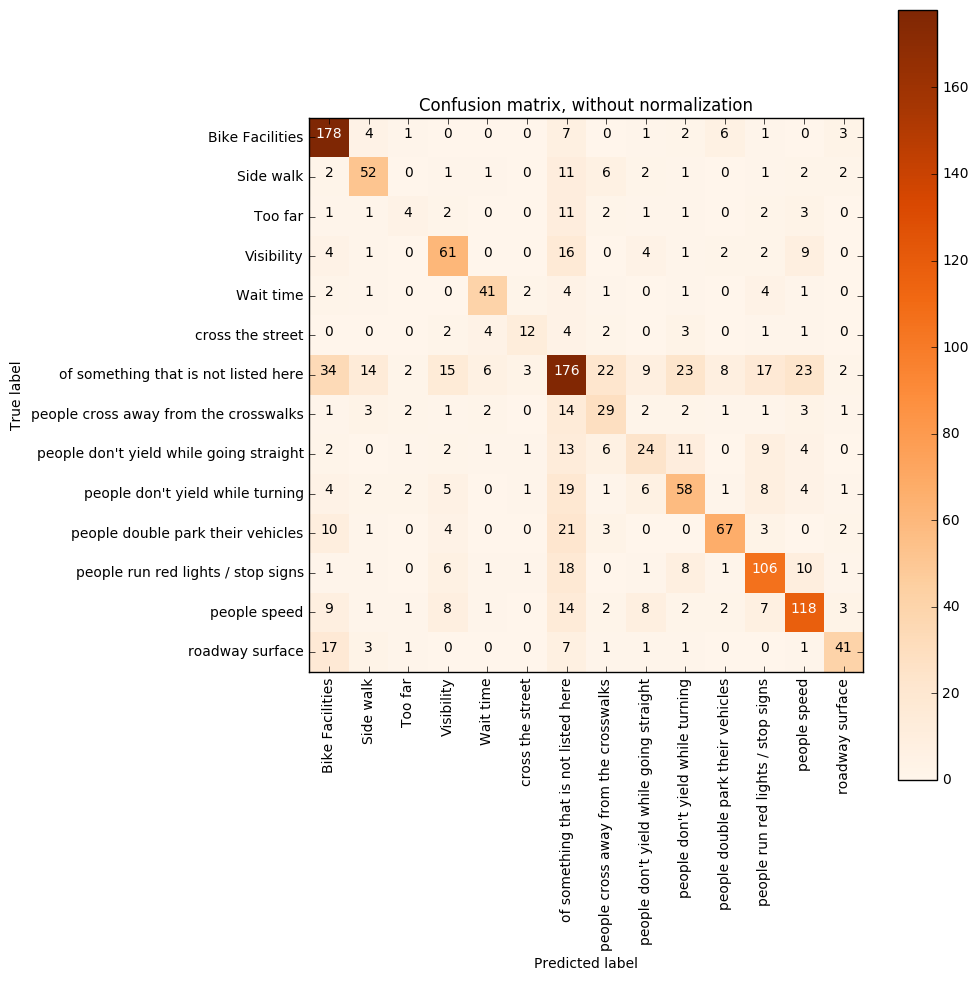

In [1080]:
aa=pd.DataFrame(aa)
bb=pd.DataFrame(aa['count'])
cc=bb.index
cc.tolist()
cnf_matrix = confusion_matrix(y_test, grid.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=cc.tolist(),
                      title='Confusion matrix, without normalization')
plt.show()

##### Mistakes made by the model

Here, apart from the diagonal elements which have been predicted correctly, we see that the categories of something that is not listed here have been predicted incorrectly

Analyzing the wrongly predicted target variables with REQUESTTYPE   **of something that is not listed here**

In [150]:
res=pd.DataFrame(grid.predict(X),index=df.index)
res = res.rename(columns={0: 'PREDICT'})
predict = pd.concat([df, res], axis=1)
# predict.to_csv('final2.csv', sep=',')

In [152]:
nomatch=predict[predict['TARGET']!=predict['PREDICT'] ]
something_not_listed=nomatch[nomatch['REQUESTTYPE']=='of something that is not listed here']
misclas=something_not_listed[['REQUESTTYPE','COMMENTS','USERTYPE','category','TARGET','PREDICT']]

In [153]:
misclas.to_csv('misclas.csv', sep=',')

# Task3 - Model 2 [30 points]

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

### Bag-of-Words with More Than One Word (n-Grams)

In [170]:
X=text_train
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,test_size=0.2)
len(text_train)

6460

In [164]:
# pipe = make_pipeline(TfidfVectorizer(), LogisticRegression()) # running the grid search takes a long time because of the
# # relatively large grid and the inclusion of trigrams
# param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
#                   "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3),(1,4)]}
# grid = GridSearchCV(pipe, param_grid, cv=5,)
# grid.fit(X_train, y_train)
# print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
# print("Best parameters:\n{}".format(grid.best_params_))
# print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
# print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

In [155]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(class_weight='balanced')) # running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
                  "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5,scoring='f1_macro')
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Best parameters:\n{}".format(grid.best_params_))


Best cross-validation score: 0.57
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


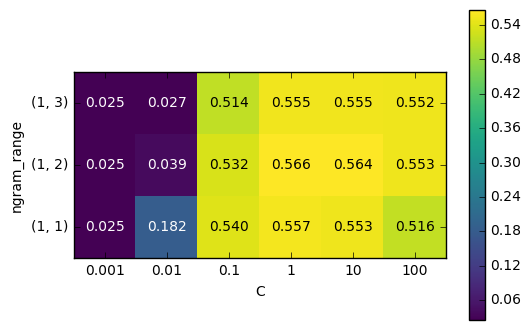

In [156]:
# extract scores from grid_search
import mglearn
import matplotlib.pyplot as plt
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T # visualize heat map
heatmap = mglearn.tools.heatmap(
        scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
        xticklabels=param_grid['logisticregression__C'],
        yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)
plt.figure(figsize=(10,10))
plt.show()

ngrams with TfidVectorizer

In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1,2)),
                         LogisticRegression(class_weight='balanced',C=1))
pipe.fit(X_train, y_train)
scores = cross_val_score(pipe, X_train, y_train, cv=5,scoring='f1_macro') 
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))
print("")
print("Training Set")
print("------------------")
score(X_train, y_train,pipe)
print(" ")
print("Test Set")
print("-----------------")
score(X_test, y_test,pipe)

Mean cross-validation accuracy: 0.57

Training Set
------------------
Score: 84.954 %
F1 Score: 87.100 %
 
Test Set
-----------------
Score: 59.257 %
F1 Score: 55.760 %


ngrams with CountVectorizer

In [1065]:
vect3 = CountVectorizer(ngram_range=(1,2),stop_words="english",min_df=1)
X = vect3.fit_transform(text_train)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
lr3 = LogisticRegression(class_weight='balanced',C=0.5).fit(X_train, y_train)
print("Training Set")
print("------------------")
score(X_train, y_train,lr3)
print(" ")
print("Test Set")
print("-----------------")
score(X_test, y_test,lr3)

Training Set
------------------
Score: 96.987 %
F1 Score: 97.539 %
 
Test Set
-----------------
Score: 60.248 %
F1 Score: 56.853 %


**This is the best overall model with an F1 score of 56.85%. **

### Character n-grams

In [1067]:
char_vect = CountVectorizer(ngram_range=(1, 2), stop_words="english", analyzer="char_wb")
X = char_vect.fit_transform(text_train)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
lr_char = LogisticRegression(C=1).fit(X_train, y_train)
print("Training Set")
print("------------------")
score(X_train, y_train,lr_char)
print(" ")
print("Test Set")
print("-----------------")
score(X_test, y_test,lr_char)

Training Set
------------------
Score: 83.137 %
F1 Score: 84.198 %
 
Test Set
-----------------
Score: 52.941 %
F1 Score: 47.769 %


Chararcter n-grams gives a bad f1 macro score

# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

##### Classification Results



In [1081]:
vect3 = CountVectorizer(ngram_range=(1,2),stop_words="english",min_df=1)
X = vect3.fit_transform(text_train)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
lr3 = LogisticRegression(class_weight='balanced',C=0.5).fit(X_train, y_train)
print("Training Set")
print("------------------")
score(X_train, y_train,lr3)
print(" ")
print("Test Set")
print("-----------------")
score(X_test, y_test,lr3)

Training Set
------------------
Score: 96.987 %
F1 Score: 97.539 %
 
Test Set
-----------------
Score: 60.248 %
F1 Score: 56.853 %


In [1082]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr3.predict(X_test), target_names=cc.tolist()))

                                         precision    recall  f1-score   support

                        Bike Facilities       0.66      0.88      0.75       203
                              Side walk       0.60      0.65      0.63        81
                                Too far       0.33      0.18      0.23        28
                             Visibility       0.57      0.62      0.60       100
                              Wait time       0.71      0.72      0.71        57
                       cross the street       0.61      0.48      0.54        29
   of something that is not listed here       0.54      0.47      0.51       354
  people cross away from the crosswalks       0.38      0.47      0.42        62
people don't yield while going straight       0.44      0.38      0.41        74
       people don't yield while turning       0.54      0.54      0.54       112
      people double park their vehicles       0.78      0.60      0.68       111
     people run red lights 

##### Confusion Matrix

Confusion matrix


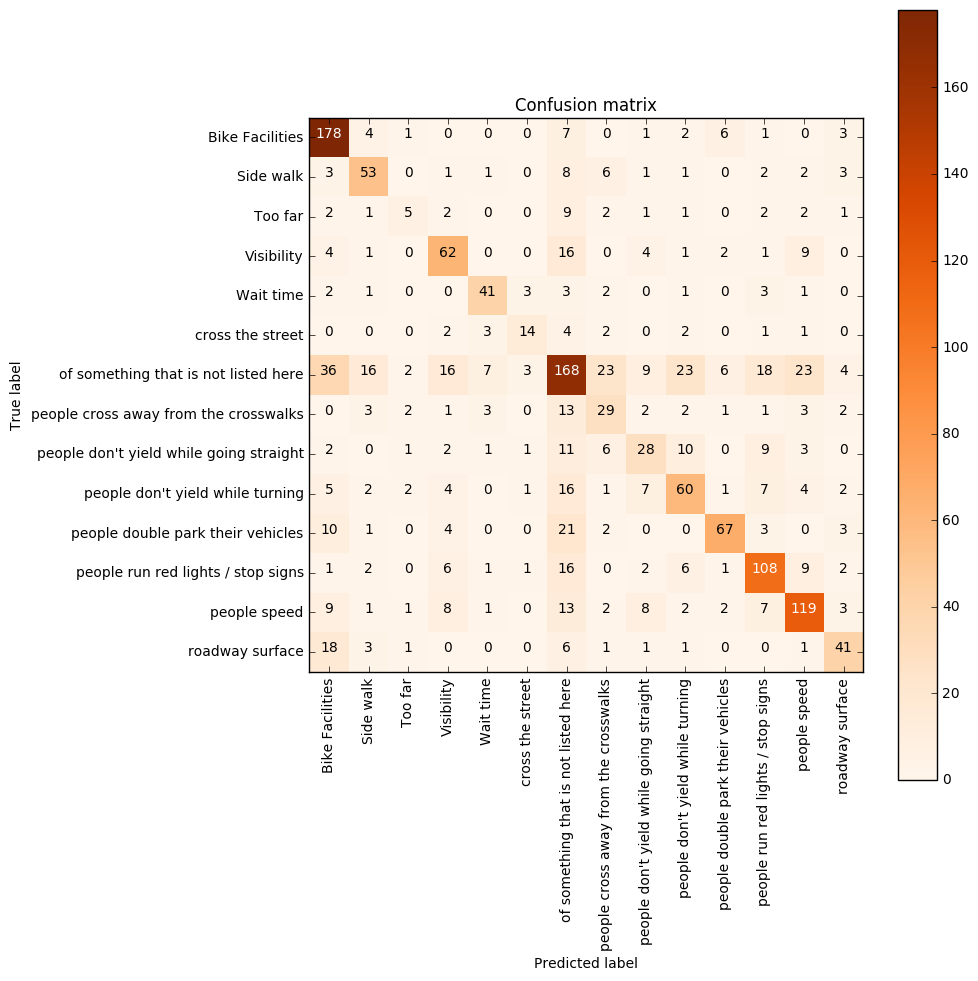

In [1083]:
cnf_matrix = confusion_matrix(y_test, lr3.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=cc.tolist(),
                      title='Confusion matrix')
plt.show()

##### Important Features

In [1084]:
from sklearn.linear_model import LogisticRegressionCV
vect3 = CountVectorizer(ngram_range=(1,2),stop_words="english",min_df=1)
X = vect3.fit_transform(text_train)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
lr = LogisticRegression(class_weight='balanced',C=0.5).fit(X_train, y_train)
print("Training Set")
print("------------------")
score(X_train, y_train,lr)
print(" ")
print("Test Set")
print("-----------------")
score(X_test, y_test,lr)

Training Set
------------------
Score: 96.987 %
F1 Score: 97.539 %
 
Test Set
-----------------
Score: 60.248 %
F1 Score: 56.853 %


In [1085]:
def plot_important_features(coef, feature_names, titl, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    ax.set_title(titl)
    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=60, ha="right")

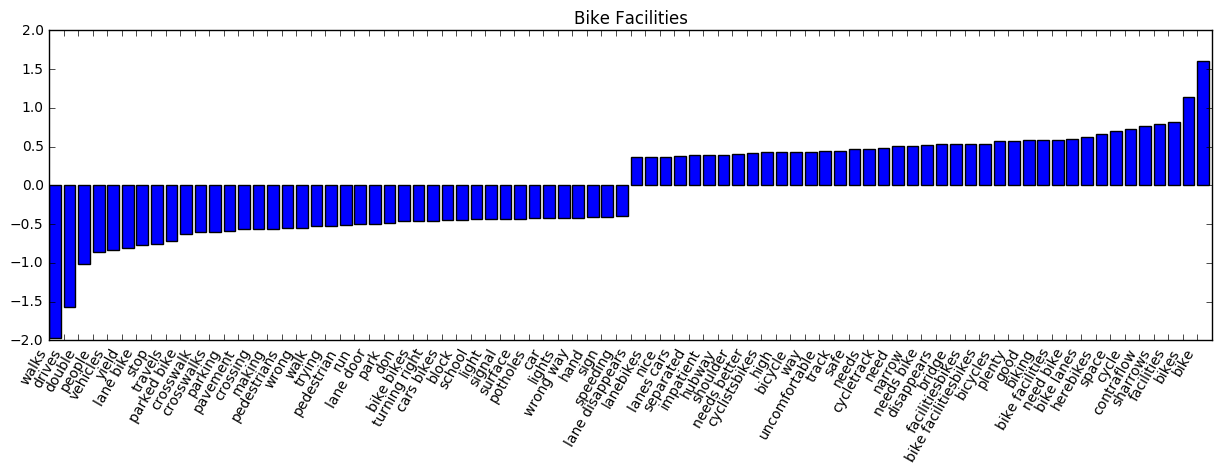

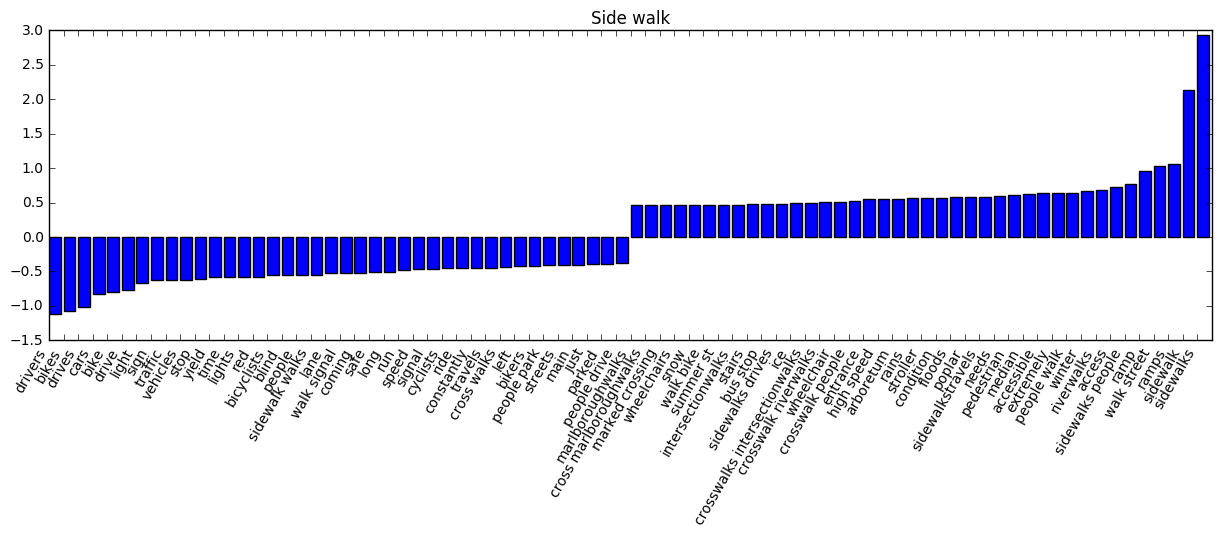

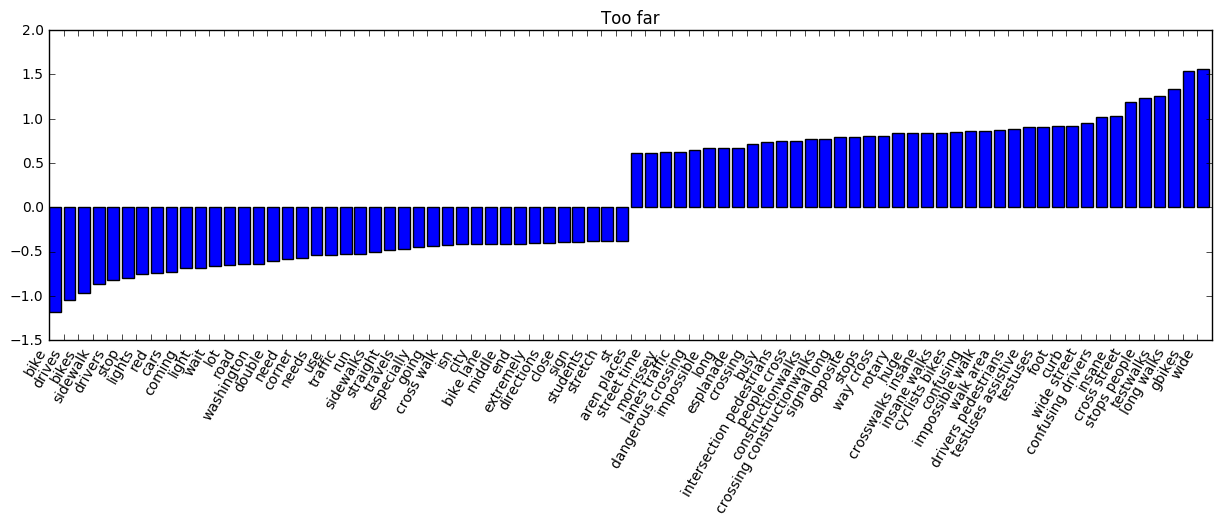

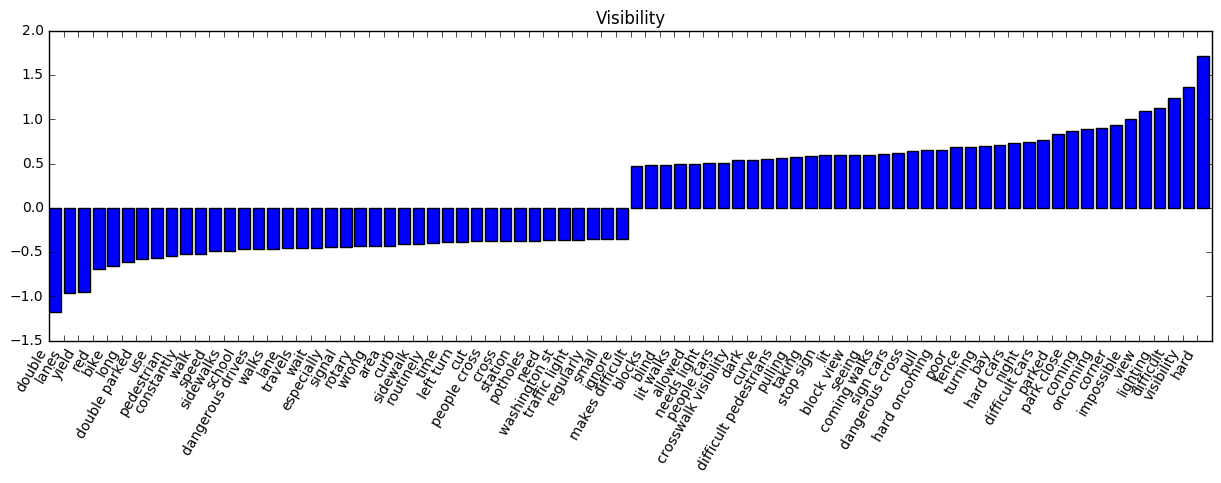

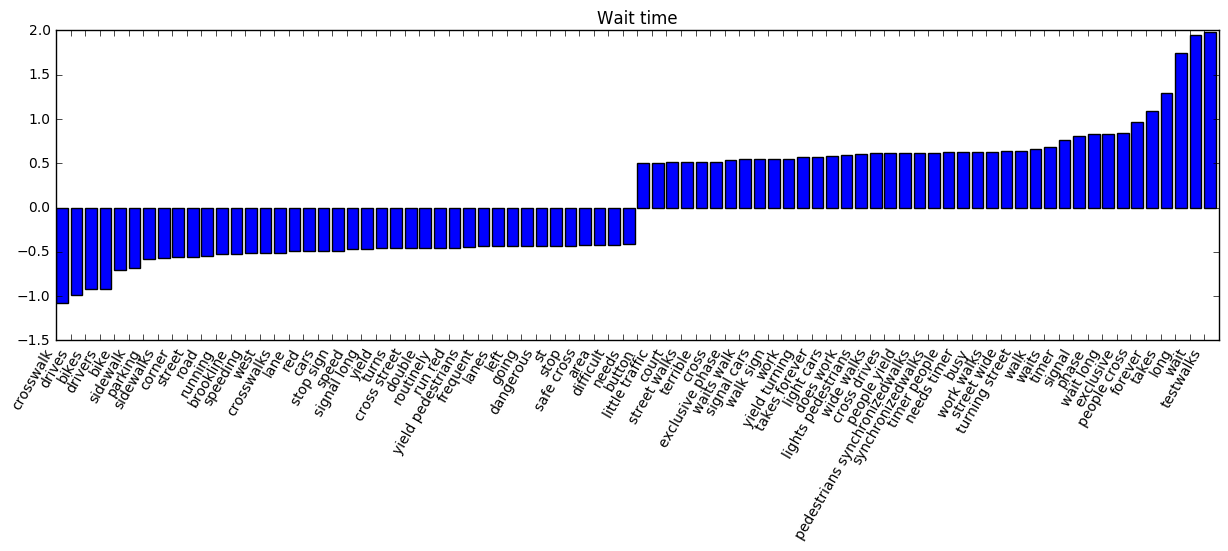

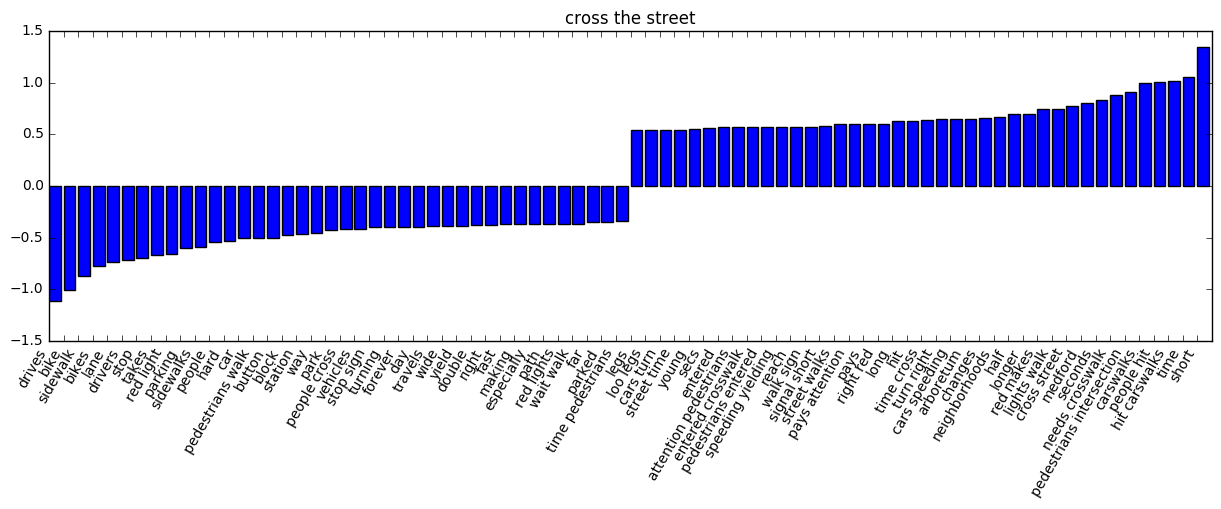

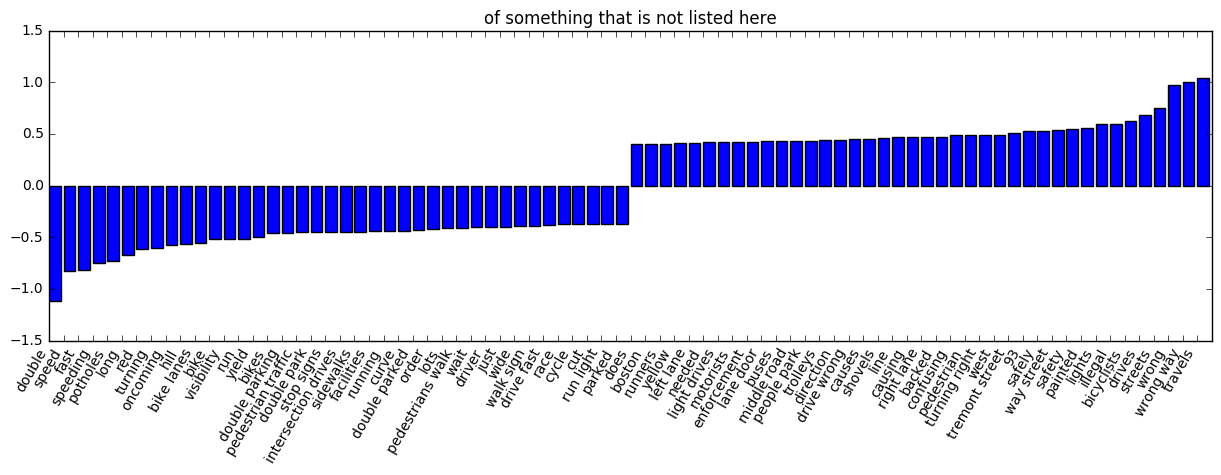

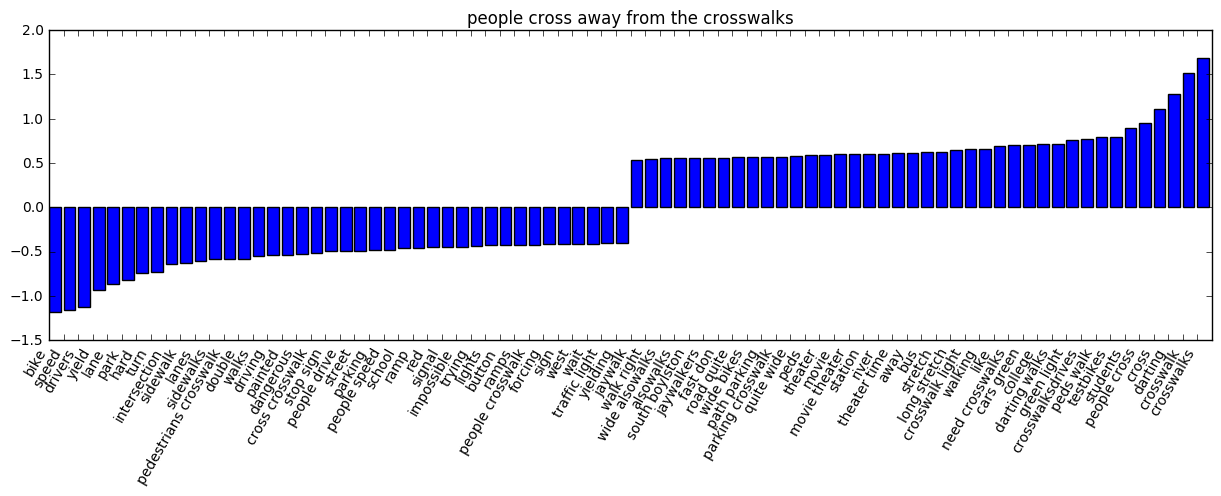

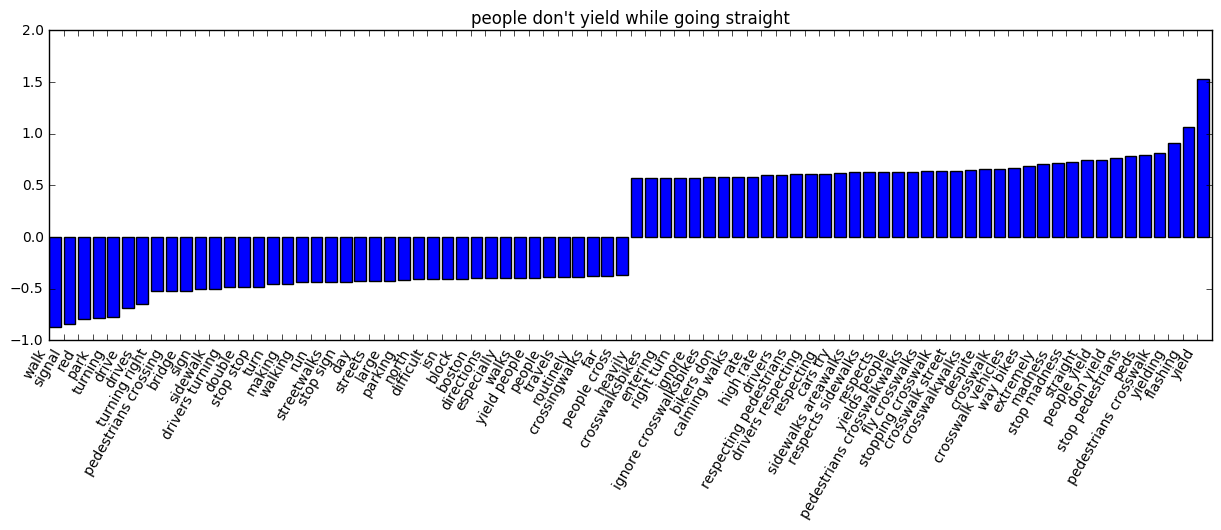

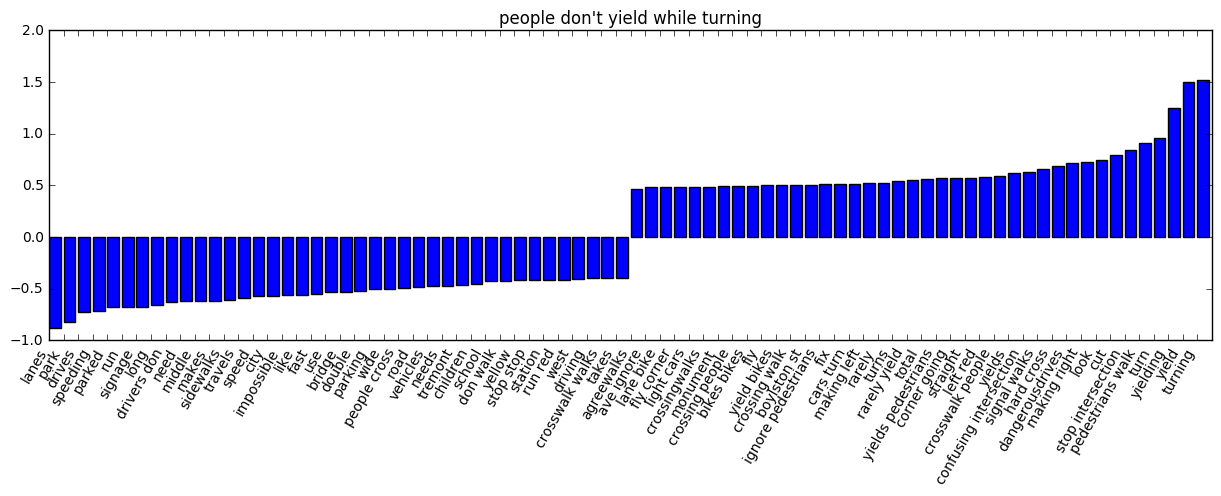

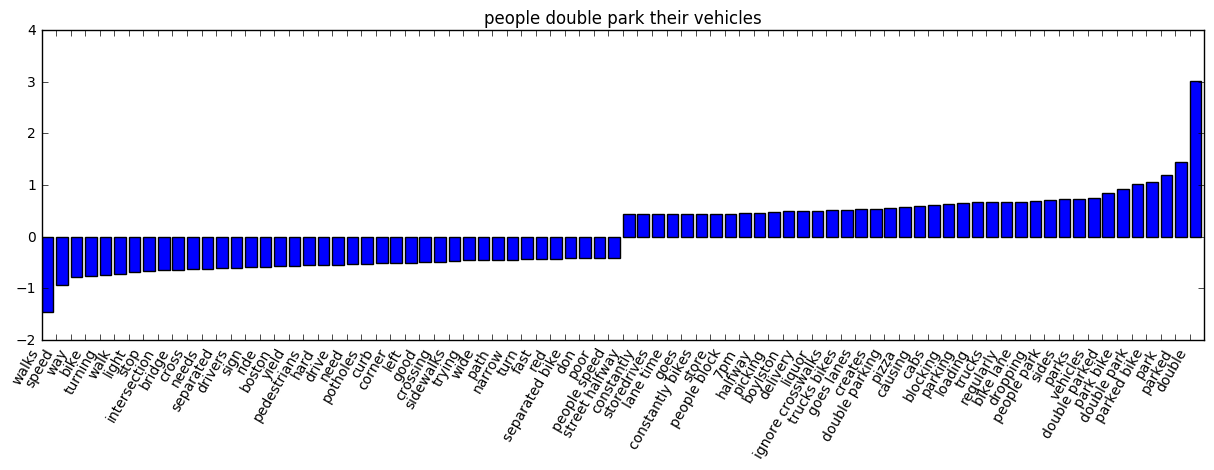

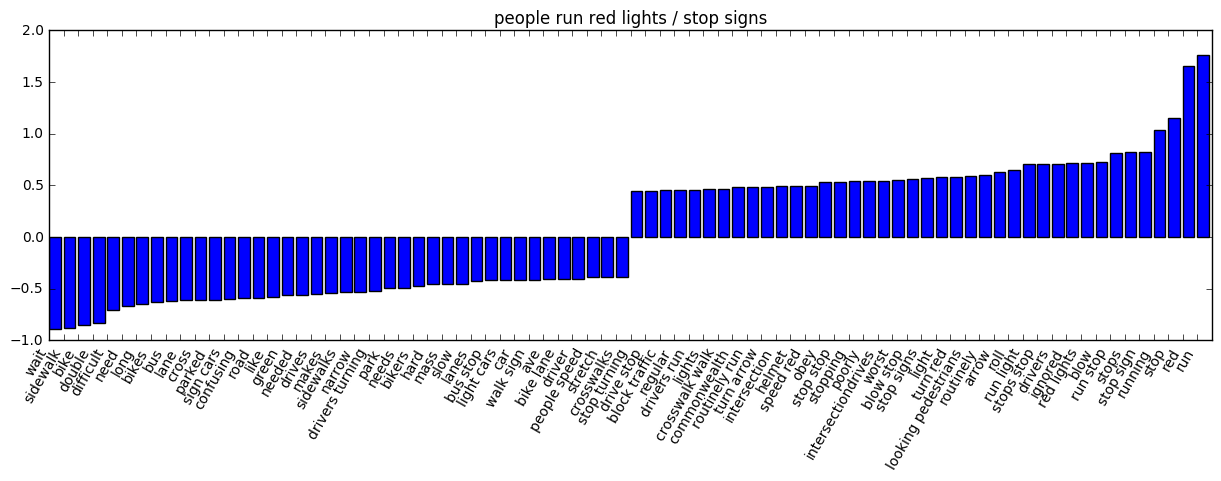

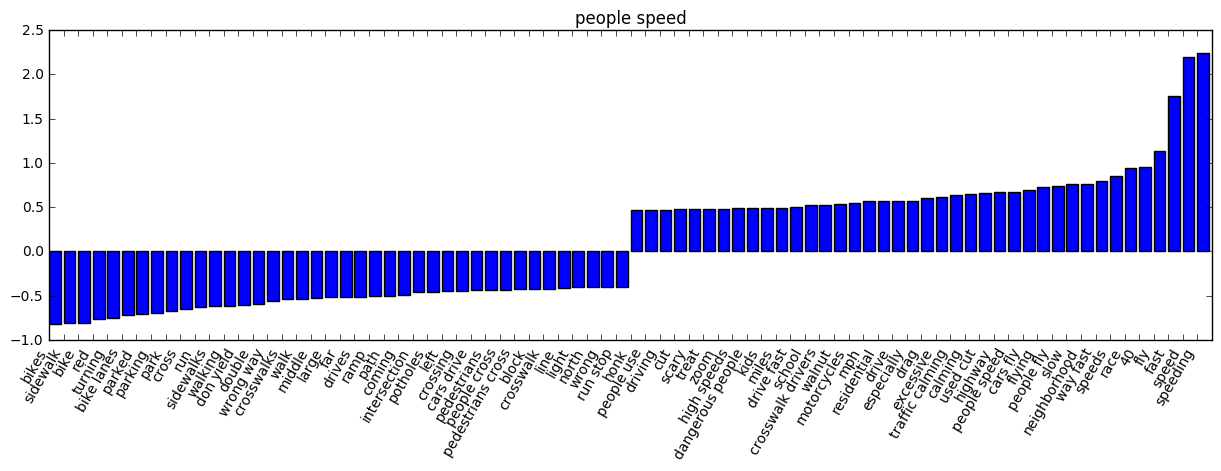

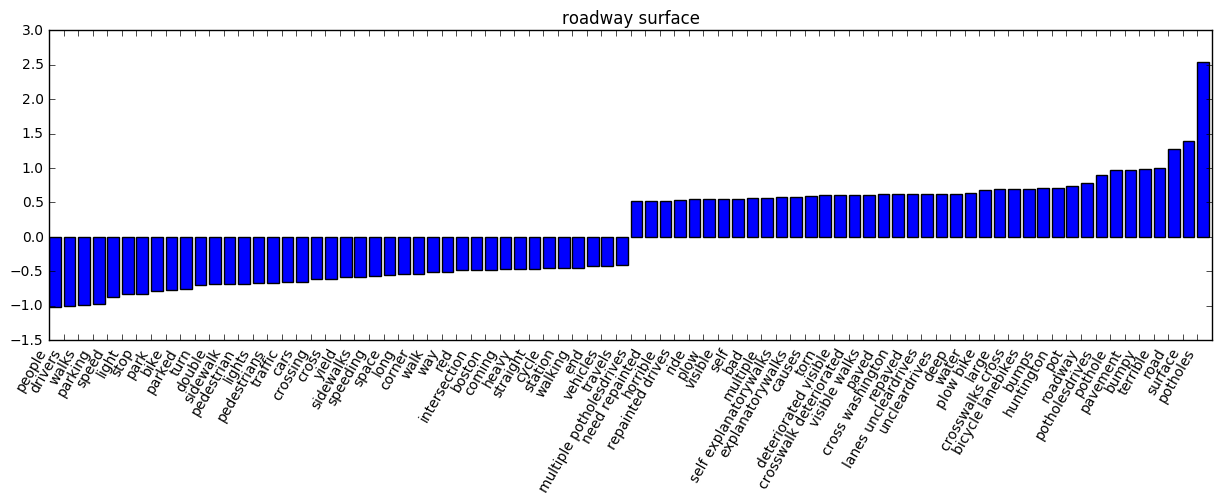

In [1086]:

for i in range(lr3.coef_.shape[0]):
    plt.figure(figsize=(15, 4))
    plot_important_features(lr3.coef_[i], np.array(vect3.get_feature_names()), cc.tolist()[i],top_n=40)
    plt.show()

##### Example Mistakes

Some example mistakes are shown below:
- 100 of the 716 misclassifications happen when the predicted output is 'Bike facilities' which corresponds to category 0. This happens because there are a large no. of sample for 'Bike facilities in the training data'. Also the model places high weight on the feature 'bikes' and tends to classify any record with the 'bikes' in this category. Cases where usertpe is 'bikes' account for 76 of these 100 misclassifications.

- 219 of the 716 misclassifications occur when the model uses the trained model to predict on the 'Other' category. After manual inspection, it seems that the model does in fact assign correct labels to many of the records, however,due to human error/user unpredictability these are incorrectly classified to begin with. 

- 164 of the 716 misclassifications occur when the output is predicted as 'Other' instead of the ground truth. This happens because the 'Other' ctegory is very broad and contains a very large no. of samples.

# Task5 - Clustering [10 points]

Apply LDA, NMF and K-Means to the whole dataset. Can you find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

### NMF

In this section, we try non negative matrix factorization with different parameters and plot the most important features.

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(stop_words="english", min_df=4)
X = vect.fit_transform(text_train)
X.shape

(6460, 2066)

*NMF without scaling*

In [378]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=100, verbose=10, tol=0.01)
X_nm_noscale = nmf.fit_transform(X)

violation: 1.0
violation: 0.3732632134530885
violation: 0.2832891775628179
violation: 0.18768802117841435
violation: 0.12311043873865765
violation: 0.06414166265940707
violation: 0.03211717321728675
violation: 0.018974726571522535
violation: 0.012903355407507103
violation: 0.010042815721117152
violation: 0.008785278835247988
Converged at iteration 11


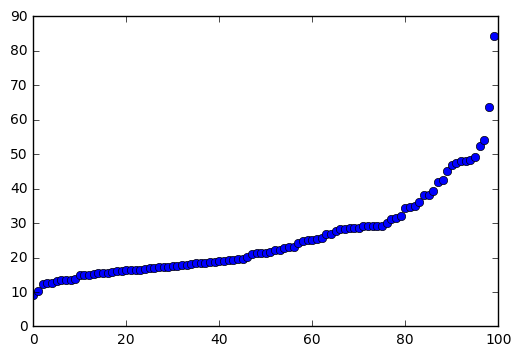

In [379]:
plt.plot(np.sort(nmf.components_.sum(axis=1)), "o")

In [ ]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

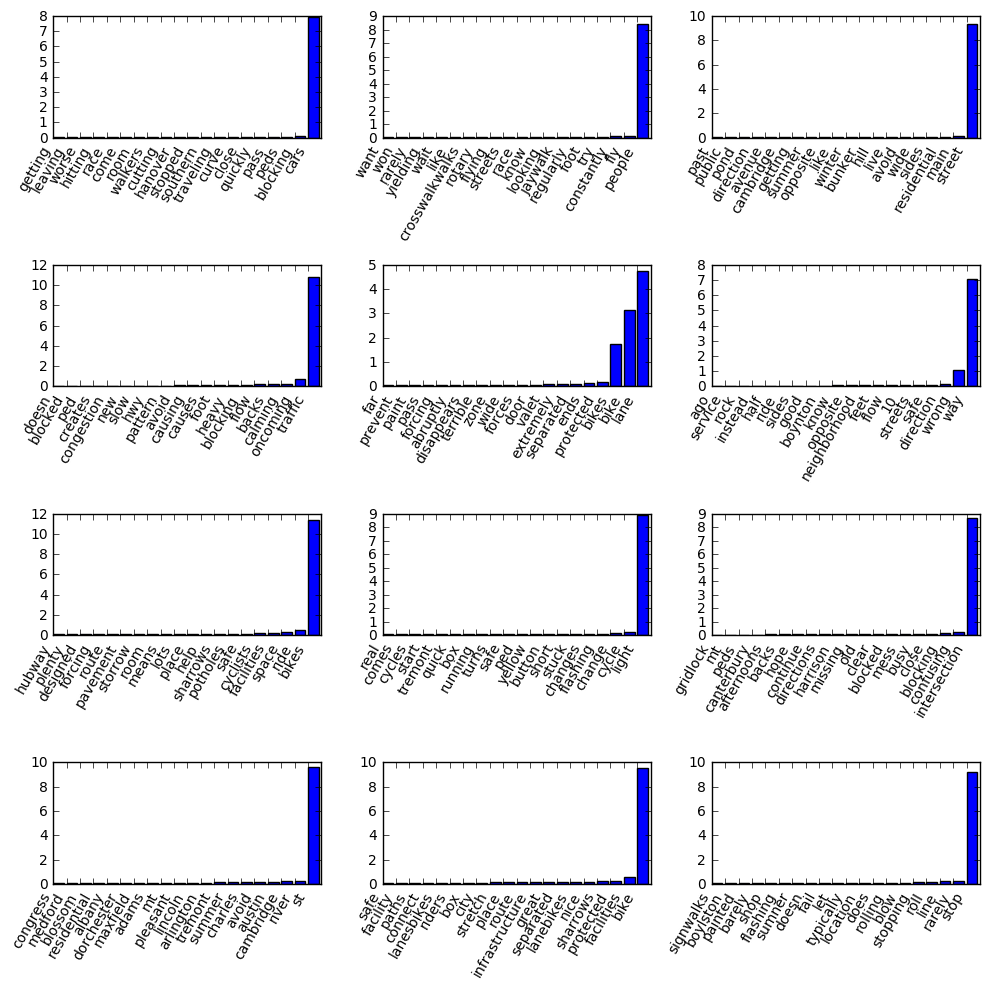

In [381]:
large_comp_inds = np.argsort(X_nm_noscale.mean(axis=0))[-12:][::-1]

feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

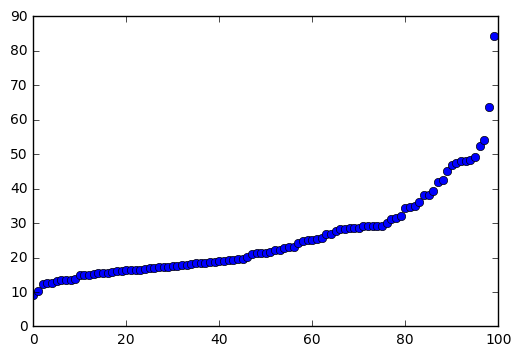

In [382]:
plt.plot(np.sort(nmf.components_.sum(axis=1)), "o")

In [128]:
def print_topics(topics, feature_names, components, topics_per_chunk=6,
                 n_words=20):
    sorting = np.argsort(components, axis=1)[:, ::-1]
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [395]:
sorting = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(large_comp_inds, feature_names, sorting)

topic 4       topic 6       topic 3       topic 5       topic 1       topic 13      
--------      --------      --------      --------      --------      --------      
alleviate     dozens        adults        convenience   mountfort     minutes       
storrow       stay          sycamore      terrible      temple        timewalks     
4pm           putting       harvard       raised        2nd           recipe        
goes          puts          gotten        rains         regular       recently      
forget        pushing       ground        rain          regardless    bearing       
got           pushed        actual        rails         regard        recent        
gridlock      push          hotel         railroad      refuse        reason        
evenings      purpose       birmingham    rail          concurrent    rear          
excessive     ambiguous     faster        additionally  reflective    really        
edge          35            feels         bollards      redwalks 

##### TFIDF with 100 components on whole input dataset



This section implements NMF for topic modeling for the input text data i.e. comments and usertype. The no. of components was set as 100 after trying different values. Taking too few components makes the topics very broad as such only the top few categories appear in the final classification. Taking more components gives a better balance across categories.

In [1206]:
vect = TfidfVectorizer(min_df = 1,ngram_range=(1,2))
X_tfidf = vect.fit_transform(text_train)
from sklearn.decomposition import NMF
nmf = NMF(n_components=100, verbose=10, tol=0.001)
X_nmf_tfidf = nmf.fit_transform(X_tfidf)

violation: 1.0
violation: 0.5834254558420422
violation: 0.7279491539519654
violation: 0.6149437139074099
violation: 0.48043218089058737
violation: 0.3625004424721812
violation: 0.2909446568892296
violation: 0.2581302983514636
violation: 0.24525432174177206
violation: 0.2421364239926049
violation: 0.24030606451473988
violation: 0.2147334728901134
violation: 0.1687071215065743
violation: 0.12305664234978858
violation: 0.09677563564859407
violation: 0.08140763794922574
violation: 0.07145981634576774
violation: 0.06503087709748907
violation: 0.0598558091610043
violation: 0.05461053793731431
violation: 0.04848207891243262
violation: 0.04280356204809126
violation: 0.038153464204699714
violation: 0.03453303589010381
violation: 0.031443597674112665
violation: 0.02863185277962688
violation: 0.026295801778439862
violation: 0.02439180862061245
violation: 0.022467746215490355
violation: 0.02093747403540628
violation: 0.02066081922170446
violation: 0.02079059233764317
violation: 0.01931131389629062

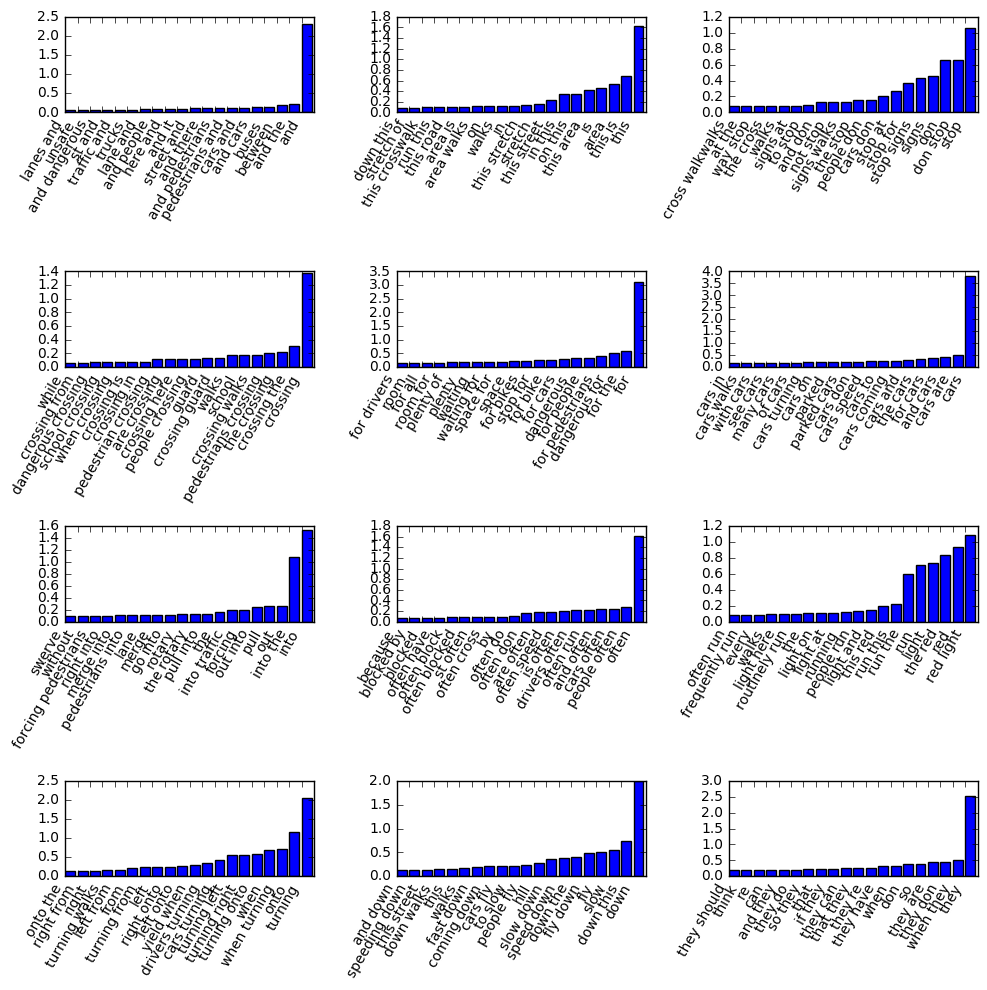

In [1207]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")
    

large_comp_inds = np.argsort(X_nmf_tfidf.mean(axis=0))[-12:][::-1]

feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

For the top 12 largest components, the coefficients of the top 20 features are shown here. Top features are listed below for each of the 100 topics.

In [1208]:
large_comp_inds = list(range(0,100))

sorting = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(large_comp_inds, feature_names, sorting)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       
--------      --------      --------      --------      --------      --------      
even trying   causes increasedduring past   egalitarian slowcharles stationchestnut southbound
times at      the bridgedrivestakes away    temporary roadsthat thin     the eyes      
as approachingre mostly     ramps vehiclesrdwalks       really you    recent replacement
as both       re not        rampswalks    re            realy         recent roadwork
at visconti   re noticed    rampuses      re 250        realy hard    recent weeks  
redesign forcesre on         rampuses an   re able       barely usable recently      
bfd           re practicallyrampwalks     re actually   realy the     recently added
2015          re sealed     ran           re aiming     rear          recently became
redesign it   re sort       ran along     re alignment  rear access   recently because
redesign of   re speeding   ran end       r

Topic labels were set by assigning the most frequently occuring **CATEGORY** in all the records that gave the highest coefficient for each topic.

In [1209]:
clusters = []

for i in X_nmf_tfidf:
    clusters.append(np.argmax(i))  

ans = []

for c in range(0,100):

    r = []

    for i in range(0,len(text_train)):

        if clusters[i] == c: 
            r.append(df.iloc[i]['category'])

    t = float('-inf')
    maxi = ''
    
    for h in set(r):
        
        if r.count(h) > t:
            t = r.count(h)
            maxi = h
            
        
    ans.append(maxi)


Topic assignments were used to predict labels for each record in the input dataset and ARI score of 0.044 was computed. 

In [1210]:
true_label = df['category']
pred  = []

for i in range(0, len(text_train)):
    pred.append(ans[clusters[i]])  
    
pred_label = np.array(pred)

from sklearn.metrics import adjusted_rand_score as ari
print("ARI score for LDA: {:.3f}".format(ari(true_label,pred_label)))

ARI score for LDA: 0.045


### LDA

Remove words that appear in at least 15 percent of the comments, and limiting the bag-of-words model to the 10,000 words that are most common after removing the top 15 percent

In [112]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

Learn a topic model with 10 topics, which is few enough that we can look at all of them. Using the "batch" learning method, which is somewhat slower than the default ("online") but usually provides better results, and increase "max_iter", which can also lead to better models

In [113]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch",max_iter=25, random_state=0) 
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once 
document_topics = lda.fit_transform(X)

The size of components_ is (n_topics, n_words)

In [114]:
lda.components_.shape

(10, 7161)

Looking at the most important words for each of the topics

In [115]:
# For each topic (a row in the components_), sort the features (ascending) # Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

In [116]:
# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names,
                                sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
lane          down          way           parking       very          
turn          see           one           lane          road          
left          speed         be            park          sidewalk      
onto          too           both          double        poor          
right         other         that          parked        lane          
st            fast          two           into          been          
turning       way           road          trucks        dangerous     
ave           no            speed         an            have          
lanes         very          lanes         or            by            
straight      school        needs         lot           narrow        


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
red 

Judging from the important words, topic 1 seems to be about turns , topic 2 and 3 might be about speed, topic 4 and 9 might be about parking. Topic 5 seems to capture signs, red lights, while topic 6 appears to be about cross-walks and  Using only 10 topics, each of the topics needs to be very broad, so that they can together cover all the different kinds of reviews in our dataset.

In [117]:
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=25, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

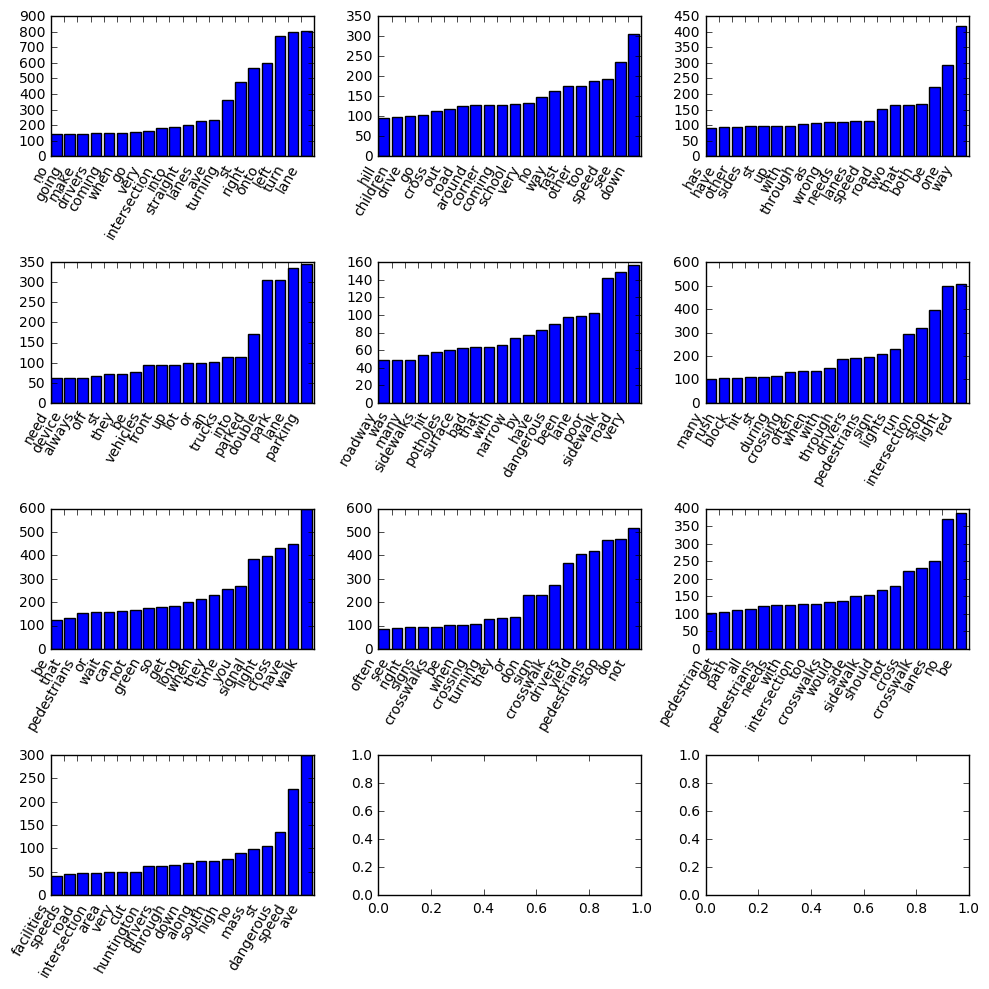

In [122]:
feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

In [28]:
vect3 = CountVectorizer(ngram_range=(1,2),stop_words="english",min_df=1)
X = vect3.fit_transform(text_train)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
lr3 = LogisticRegression(class_weight='balanced',C=1).fit(X_train, y_train)
print("Training Set")
print("------------------")
score(X_train, y_train,lr3)
print(" ")
print("Test Set")
print("-----------------")
score(X_test, y_test,lr3)

Training Set
------------------
Score: 98.596 %
F1 Score: 98.873 %
 
Test Set
-----------------
Score: 59.876 %
F1 Score: 55.935 %


In [876]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

Learn a topic model with 500 topics

In [1173]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=500, learning_method="batch",max_iter=25, random_state=0) 
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once 
document_topics = lda.fit_transform(X)

The size of components_ is (n_topics, n_words)

In [1174]:
lda.components_.shape

(500, 54509)

In [1177]:
# large_comp_inds = np.argsort(document_topics.mean(axis=0))[-50:][::-1]

# feature_names = np.array(vect.get_feature_names())
# n_components = 50
# fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 50))
# for i, (ax, coef) in enumerate(zip(axes.ravel(), lda.components_[:, :])):
#     plot_important_features(coef, feature_names, top_n=20, ax=ax)
#     ax.set_title(i)
    
# plt.tight_layout()

Looking at the most important words for each of the topics

In [1178]:
# For each topic (a row in the components_), sort the features (ascending) # Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

In [1179]:
# Print out the 13 topics:
mglearn.tools.print_topics(topics=range(50), feature_names=feature_names,
                                sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
creating confusionneeds physicalnor are       on deer       boardwalk informing
corner is     deter running to 66         boardwalk informingcorner is     
speeding mergingat light      corner is     playground withmatter the    
without regardbaby in       to sometimes  no clear      calming methods
ride safely   signal becauseshows up      mass commissionugly bikes    


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
the cars      pomfret streetit ends       authority doesbend drives   
playground withsequence      authority doesthe supermarketugly bikes    
speed signs   with their    playground withbumps installedcerina        
rampant       parked school use this      present for   cerina to     
path has      years back    roadwalks     sudbury fr

In [1180]:
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=25, mean_change_tol=0.001,
             n_jobs=1, n_topics=500, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

Predicting the topics for each comment

In [1181]:
doc_topic_dist_unnormalized = np.matrix(lda.transform(X))

In [1182]:
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)

In [1191]:
data=df
cluster=pd.DataFrame(doc_topic_dist.argmax(axis=1).tolist())
cluster.shape

(6460, 1)

In [1192]:
ans = []

for c in range(0,500):

    r = []
    print('Cluster ', c)

    for i in range(0,len(text_train)):

        if clusters[i] == c: 

    #         print(text_train[i],'   ', clusters[i])
    #         print(df2.iloc[i]['COMMENTS'], '  ', df2.iloc[i]['REQUESTTYPE'])
    #         print

            r.append(df.iloc[i]['category'])

    t = float('-inf')
    maxi = ''
    
    for h in set(r):
        
        if r.count(h) > t:
            t = r.count(h)
            maxi = h
            
        
    ans.append(maxi)

Cluster  0
Cluster  1
Cluster  2
Cluster  3
Cluster  4
Cluster  5
Cluster  6
Cluster  7
Cluster  8
Cluster  9
Cluster  10
Cluster  11
Cluster  12
Cluster  13
Cluster  14
Cluster  15
Cluster  16
Cluster  17
Cluster  18
Cluster  19
Cluster  20
Cluster  21
Cluster  22
Cluster  23
Cluster  24
Cluster  25
Cluster  26
Cluster  27
Cluster  28
Cluster  29
Cluster  30
Cluster  31
Cluster  32
Cluster  33
Cluster  34
Cluster  35
Cluster  36
Cluster  37
Cluster  38
Cluster  39
Cluster  40
Cluster  41
Cluster  42
Cluster  43
Cluster  44
Cluster  45
Cluster  46
Cluster  47
Cluster  48
Cluster  49
Cluster  50
Cluster  51
Cluster  52
Cluster  53
Cluster  54
Cluster  55
Cluster  56
Cluster  57
Cluster  58
Cluster  59
Cluster  60
Cluster  61
Cluster  62
Cluster  63
Cluster  64
Cluster  65
Cluster  66
Cluster  67
Cluster  68
Cluster  69
Cluster  70
Cluster  71
Cluster  72
Cluster  73
Cluster  74
Cluster  75
Cluster  76
Cluster  77
Cluster  78
Cluster  79
Cluster  80
Cluster  81
Cluster  82
Cluster  83
Cl

In [1193]:
pred  = []

for i in range(0, len(text_train)):
    pred.append(ans[clusters[i]])

In [1203]:
#Unique topics predicted
set(pred)

{'Bike Facilities',
 'Side walk',
 'Visibility',
 'Wait time',
 'cross the street',
 'of something that is not listed here',
 'people cross away from the crosswalks',
 "people don't yield while going straight",
 "people don't yield while turning",
 'people double park their vehicles',
 'people run red lights / stop signs',
 'people speed'}

In [1195]:
pred_label=np.array(pred)
true_label=np.array(df['category'])

In [1197]:
from sklearn.metrics import adjusted_rand_score as ari
print("ARI score for LDA: {:.3f}".format(ari(true_label,pred_label)))

ARI score for LDA: 0.047


The ARI score for LDA is slightly better than NMF. This could be due to the fact that a very high no. of topics 500 in this case have been used here. 

### K-Means

K-means clustering was used to first cluster the entire input data, generate cluster labels using the most frequently occuring **category** in the cluster and calculating ARI score. 100 clusters were created. This method gave the best ARI score of 0.137.

In [1158]:
df=no_dup
df = df[pd.notnull(df['COMMENTS'])]
df.shape

(6460, 13)

In [1159]:
text_train= list(df["COMMENTS"].map(str)+df["USERTYPE"])
y=list(df["TARGET"])

In [1200]:
tfidf_vectorizer = TfidfVectorizer(min_df=1,ngram_range=(1,2))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text_train)

from sklearn.cluster import KMeans


km = KMeans(n_clusters = 100, random_state = 42)
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 722 ms, sys: 47.8 ms, total: 769 ms
Wall time: 801 ms
CPU times: user 2min 45s, sys: 10.3 s, total: 2min 55s
Wall time: 3min 2s


In [1201]:
ans = []

for c in range(0,100):

    r = []

    for i in range(0,len(text_train)):

        if clusters[i] == c: 
            r.append(df.iloc[i]['category'])

    t = float('-inf')
    maxi = ''
    
    for h in set(r):
        
        if r.count(h) > t:
            t = r.count(h)
            maxi = h
            
        
    ans.append(maxi)



In [1202]:
true_label = df['category']
pred  = []

for i in range(0, len(text_train)):
    pred.append(ans[clusters[i]])  
    
pred_label = np.array(pred)

from sklearn.metrics import adjusted_rand_score as ari
print("ARI score for K-Means: {:.3f}".format(ari(true_label,pred_label)))

ARI score for K-Means: 0.137


# Task6 - Model 3 [30 points]

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


#### Clustering 'Other' category and using labels generated from logisitic regression for re-classification.

##### Using k-means
The data was split into two parts, one containing only records of 'Other' category and one containing the rest. A logisitic regression model was trained on part 2 and then used to predict labels for part 1. These labels were then used to label the 200 clusters created for the 'Other' category. New REQYESTTYPES were created for the "Other' category. The two datasets were then merged and logistic regression was trained on the combined dataset. The final model gave an improved f1-score of 59.74%.

In [1124]:
df4 = df[df['REQUESTTYPE'] == 'of something that is not listed here']

text_train_other = list(df4['COMMENTS'].map(str)+ df4["USERTYPE"])
tfidf_vectorizer = TfidfVectorizer(min_df=1,ngram_range=(1,2))
%time tfidf_matrix_o = tfidf_vectorizer.fit_transform(text_train_other)


km = KMeans(n_clusters = 200, random_state = 42)
%time km.fit(tfidf_matrix_o)

clusterso = km.labels_.tolist()

df3 = df[df['REQUESTTYPE'] != 'of something that is not listed here']

text_train, y_train_sub = list(df3['COMMENTS'].map(str)+ df3["USERTYPE"]), list(df3['category'])
X_test_t,y_test = list(df4['COMMENTS'].map(str)+ df4["USERTYPE"]), list(df4['category'])
vect = CountVectorizer(ngram_range=(1, 2), min_df=1)

X_train = vect.fit_transform(text_train)
X_test = vect.transform(X_test_t)


CPU times: user 200 ms, sys: 5.7 ms, total: 206 ms
Wall time: 207 ms
CPU times: user 17.6 s, sys: 1.44 s, total: 19.1 s
Wall time: 19.2 s


In [1125]:
lr = LogisticRegression(C = 1.0, penalty = 'l2', class_weight = 'balanced')
lr.fit(X_train,y_train_sub)
        
lr_pred_other = lr.predict(X_test)

In [1126]:
ans = []

for c in range(0,200):

    r = []

    for i in range(0,len(text_train_other)):

        if clusterso[i] == c: 
            r.append(lr_pred_other[i])

    t = float('-inf')
    maxi = ''
    
    for h in set(r):
        
        if r.count(h) > t:
            t = r.count(h)
            maxi = h
            
        
    ans.append(maxi)

In [1127]:
l = []
for k in range(0,1400):
    l.append(ans[clusterso[k]])
    
l = np.array(l)

In [1128]:
df5 = df4
df5['category'] = l

In [1129]:
result = pd.concat([df3,df5])
result.shape

(6460, 14)

In [1130]:
text_train, y_train_sub = list(result['COMMENTS'].map(str)+ result["USERTYPE"]), list(result['category'])

vect = CountVectorizer(ngram_range=(1, 2), min_df=1)

X_train_t,X_test_t,y_train,y_test = train_test_split(text_train, y_train_sub, random_state=42)

X_train = vect.fit_transform(X_train_t)
X_test = vect.transform(X_test_t)

In [1131]:
lr = LogisticRegression(C = 100,penalty = 'l2', class_weight = 'balanced')
lr.fit(X_train,y_train)
f1_score(y_test,lr.predict(X_test), average = 'macro')

0.59742295262751621

In [ ]:
p = f1_score(y_test,lr.predict(X_test), average = 'macro')
assert p > 0.58

##### Using LDA
The data was split into two parts, one containing only records of 'Other' category and one containing the rest. A logisitic regression model was trained on part 2 and then used to predict labels for part 1. These labels were then used to label the 1000 topics created for the 'Other' category. New REQYESTTYPES were created for the "Other' category based on the topics. The two datasets were then merged and logistic regression was trained on the combined dataset. The final model gave an improved score of 58.966%.

Predicting topics for the category 'of something that is not listed here'

In [909]:
others=df[df['category']=='of something that is not listed here']
others.shape
text_train_others= list(others["COMMENTS"].map(str)+others["USERTYPE"])
len(text_train_others)

1400

Remove words that appear in at least 15 percent of the comments, and limiting the bag-of-words model to the 10,000 words that are most common after removing the top 15 percent

In [910]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X_others = vect.fit_transform(text_train_others)

Learning a topic model with 1000 topics, as the target variable distribution is quite unbalanced

In [911]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_topics=1000, learning_method="batch",max_iter=25, random_state=0) 
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once 
document_topics = lda.fit_transform(X_others)

The size of components_ is (n_topics, n_words)

In [912]:
lda.components_.shape

(1000, 3540)

Looking at the most important words for each of the topics

In [913]:
# For each topic (a row in the components_), sort the features (ascending) # Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

In [1142]:
# Print out the 50 out of 1000 topics:
mglearn.tools.print_topics(topics=range(50), feature_names=feature_names,
                                sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
street        lane          do not        turning       there is      
the street    bike lane     do            onto          there         
this street   bike          not           turning left  is no         
street and    the bike      not yield     turning right is            
street walks  lane bikes    not stop      turning onto  no            
street is     lane is       drivers do    cars turning  and there     
street drives bikes         and do        when turning  no crosswalk  
street to     lane on       people do     drivers turningno stop       
cross the     lane and      cars do       left onto     safe          
street bikes  lane here     stop          left          no safe       


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
lig

In [915]:
lda.fit(X_others)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=25, mean_change_tol=0.001,
             n_jobs=1, n_topics=1000, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [916]:
doc_topic_dist_unnormalized = np.matrix(lda.transform(X_others))

In [917]:
doc_topic_dist = doc_topic_dist_unnormalized/doc_topic_dist_unnormalized.sum(axis=1)

In [919]:
data_others=others
data_others['Topic']=doc_topic_dist.argmax(axis=1).tolist()
check=data_others[['REQUESTTYPE','COMMENTS','USERTYPE','category','TARGET','Topic']]
check.to_csv('check.csv', sep=',')

In [920]:
no_others=df[df['REQUESTTYPE']!='of something that is not listed here'].copy()
no_others.shape

(5060, 14)

In [921]:
text_train_no_others= list(no_others["COMMENTS"].map(str)+no_others["USERTYPE"])
len(text_train_no_others)

5060

In [922]:
# text_train= list(df["COMMENTS"].map(str)+df["USERTYPE"])
no_others['NEWTARGET'] = no_others.category.cat.codes
y_no_others=list(no_others["NEWTARGET"])
set(y_no_others)
# print("type of text_train: {}".format(type(text_train)))
# print("length of text_train: {}".format(len(text_train))) 
# print("text_train[1]:\n{}".format(text_train[1]))

{0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13}

In [924]:
vect3 = CountVectorizer(ngram_range=(1,2),stop_words="english",min_df=1)
X = vect3.fit_transform(text_train_no_others)
# X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)
lr3 = LogisticRegression(class_weight='balanced',C=1).fit(X, y_no_others)
# print("Training Set")
# print("------------------")
score(X, y_no_others,lr3)
# print(" ")
# print("Test Set")
# print("-----------------")
# score(X_test, y_test,lr3)

Score: 99.289 %
F1 Score: 99.303 %


In [925]:
X_others = vect3.transform(text_train_others)
X_others.shape

(1400, 43668)

In [926]:
res=pd.DataFrame(lr3.predict(X_others),index=others.index)
res = res.rename(columns={0: 'PREDICT'})
other_predict = pd.concat([check, res], axis=1)

file=other_predict[['REQUESTTYPE','COMMENTS','USERTYPE','category','TARGET','Topic','PREDICT']]
# other_predict2=other_predict[other_predict['category']=='of something that is not listed here']

# other_predict3 = pd.concat([check, other_predict2['PREDICT']], axis=1)
# other_predict3.shape
# # file=other_predict[['REQUESTTYPE','COMMENTS','USERTYPE','category','TARGET','PREDICT']]
fi=file['Topic'].astype(str)
# fi.str.extract('(\d+)').astype(int)
fi=pd.DataFrame(fi.str.extract('(\d+)').astype(int))
file = file.drop('Topic', 1)
final = pd.concat([file, fi], axis=1)
final
final.to_csv('finallly.csv', sep=',')

In [927]:
a=final.groupby(['Topic', 'PREDICT']).size()
a = a.to_frame().reset_index()
a = a.rename(columns= {0: 'count'})
a = a.rename(columns= {'PREDICT': 'pred'})
b=a[a['count'] == a.groupby(['Topic'])['count'].transform(max)]

In [929]:
c=b.groupby(['Topic']).max()
c = c.reset_index()
c.shape

(473, 3)

In [931]:
mer=final.reset_index().merge(c, how="left").set_index('index')

In [932]:
mer.to_csv('finall2.csv', sep=',')

In [933]:
new_others=no_others[['USERTYPE','COMMENTS','NEWTARGET']]
new_others = new_others.rename(columns= {'NEWTARGET':'TARGET'})
new_others.shape

(5060, 3)

In [934]:
new_others

,USERTYPE,COMMENTS,TARGET
0,bikes,the roadway is super wide here with no lane ma...,0
1,walks,As someone who walks from SE of the intersecti...,4
2,walks,I'm one of those people. Many people walk nort...,7
4,drives,People do not understand which lane to move in...,9
5,walks,I rarely use the crosswalk because the light h...,7
6,walks,"MBTA bus 35, 36, & 37 drop off passengers at B...",7
7,walks,Dangerous intersection to cross for pedestrian...,4
10,bikes,Dangerous pinch point for cyclists going North...,0
11,bikes,Double parking all up and down Broadway.,10
12,bikes,Rampant Double Parking.,10


In [935]:
new_no_others=mer[['USERTYPE','COMMENTS','pred']]
new_no_others = new_no_others.rename(columns= {'pred':'TARGET'})
new_no_others.shape

(1400, 3)

In [936]:
new_df_lda=new_others.append(new_no_others)
new_df_lda=new_df_lda.sort()
new_df_lda.shape
# new_df_lda=new_df_lda.sort_index
# new=new_df_lda.sort_index(inplace=True)
# new

(6460, 3)

In [938]:
lda_text_train= list(new_df_lda["COMMENTS"].map(str)+new_df_lda["USERTYPE"])
lda_y=list(new_df_lda["TARGET"])
# print("type of text_train: {}".format(type(text_train)))
# print("length of text_train: {}".format(len(text_train))) 
# print("text_train[1]:\n{}".format(text_train[1]))

In [940]:
lda_X

<6460x54509 sparse matrix of type '<class 'numpy.int64'>'
	with 166048 stored elements in Compressed Sparse Row format>

In [941]:
from sklearn.linear_model import LogisticRegressionCV
vect3 = CountVectorizer(ngram_range=(1,2),stop_words="english",min_df=1)
lda_X = vect3.fit_transform(lda_text_train)
X_train, X_test, y_train, y_test = train_test_split(lda_X, lda_y,random_state=42)
lr = LogisticRegression(class_weight='balanced',C=1).fit(X_train, y_train)
print("Training Set")
print("------------------")
score(X_train, y_train,lr)
print(" ")
print("Test Set")
print("-----------------")
score(X_test, y_test,lr)

Training Set
------------------
Score: 99.278 %
F1 Score: 99.344 %
 
Test Set
-----------------
Score: 64.582 %
F1 Score: 58.966 %


# Extra Credit [Up to +20 points]

In this section we have used a word embedding representation namely word2vec for step 3 and or step 6. 

word2vec with genism



In [942]:
from gensim import models
w = models.KeyedVectors.load_word2vec_format(
    '/Users/kaavyachinniah/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

In [943]:
w['queen'].shape

(300,)

In [944]:
w.syn0.shape

(3000000, 300)

##### Using Step 3

In [945]:
vect_w2v = CountVectorizer(vocabulary=w.index2word)
vect_w2v.fit(text_train)
docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train))
docs[0]

array(['is', 'with', 'the', 'it', 'but', 'so', 'no', 'only', 'get', 'back',
       'where', 'way', 'go', 'around', 'here', 'too', 'cars', 'fast',
       'wide', 'ride', 'lots', 'mass', 'trucks', 'super', 'lane', 'bikes',
       'confusing', 'roadway', 'frightening', 'westbound', 'markings',
       'ave'], 
      dtype='<U98')

In [1005]:
X_w2v=np.empty([len(docs),300])
X_w2v.shape

(6460, 300)

In [1006]:
i=0
for doc in docs:
#     print(doc)
    if len(doc)!=0:
#         print(doc)
        a=np.mean(w[doc], axis=0)
        X_w2v[i]=a
    i=i+1    

In [1009]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y,random_state=42)
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5,scoring='f1_macro') 
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)
print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Best cross-validation score: 0.52
Best parameters:  {'C': 10}
Score: 52.588 %
F1 Score: 52.588 %


Using word2vec, after grid search gives a final F1 score of 52.88%. Since this does not give an improvement over our best scores, it has not been included in the final bag of words model.

##### Using Step 6

word2vec was also used for step 6. However, it gave an F1 score of 54.36% after tuning the model which was not an improvement over our best score. Hence it was not included in the final model.

In [1010]:
vect_w2v = CountVectorizer(vocabulary=w.index2word)
vect_w2v.fit(lda_text_train)
docs = vect_w2v.inverse_transform(vect_w2v.transform(lda_text_train))
docs[0]

array(['is', 'with', 'the', 'it', 'but', 'so', 'no', 'only', 'get', 'back',
       'where', 'way', 'go', 'around', 'here', 'too', 'cars', 'fast',
       'wide', 'ride', 'lots', 'mass', 'trucks', 'super', 'lane', 'bikes',
       'confusing', 'roadway', 'frightening', 'westbound', 'markings',
       'ave'], 
      dtype='<U98')

In [1013]:
lda_X_w2v=np.empty([len(docs),300])
lda_X_w2v.shape

(6460, 300)

In [1014]:
i=0
for doc in docs:
#     print(doc)
    if len(doc)!=0:
#         print(doc)
        a=np.mean(w[doc], axis=0)
        lda_X_w2v[i]=a
    i=i+1    

In [1023]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
X_train, X_test, y_train, y_test = train_test_split(lda_X_w2v, lda_y,random_state=42)
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5,scoring='f1_macro') 
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)
print('Score: {:.3f} %'.format(grid.score(X_test,y_test)*100))
print('F1 Score: {:.3f} %'.format(f1_score(y_test, grid.predict(X_test),average='macro')*100))

Best cross-validation score: 0.54
Best parameters:  {'C': 10}
Score: 54.363 %
F1 Score: 54.363 %
